In [1]:
#---------------------------------------------------------------------------------
#                                 _             _      
#                                | |_  ___ _ __(_)__ _ 
#                                | ' \/ -_) '_ \ / _` |
#                                |_||_\___| .__/_\__,_|
#                                         |_|          
#
#---------------------------------------------------------------------------------
#
# Company: HEPIA // HES-SO
# Engineer: Hugo Varenne <hugo.varenne@master.hes-so.ch>
# 
# Project Name: Unleashing the Full Potential of 
#               High-Performance Cherenkov Telescopes
#               with Fully-Digital Solid-State Sensors Camera
#
# File: 5.0_Custom_Model_Usage.ipynb
# Description: Notebook for creating models using CTLearn
#
# Last update: 2025-10-02
#
#--------------------------------------------------------------------------------

# Custom model handling

### Imports

In [1]:
import sys
import os
import importlib
import glob
import shutil
import hdf5plugin, h5py
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from ctapipe.io import EventSource
from sklearn import metrics
import importlib
import numpy as np
import time
import json
from ctlearn.tools.predict_model import MonoPredictCTLearnModel, StereoPredictCTLearnModel
from ctlearn.utils import validate_trait_dict
import keras
from tensorflow.keras import Input, Model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
from ctlearn.tools.train_model import TrainCTLearnModel
from ctlearn.core.model import SingleCNN
from ctapipe.core.traits import ComponentName
from traitlets.config import Config
import yaml


# Custom tools
tools_path = os.path.join("../tools")
if tools_path not in sys.path:
    sys.path.append(tools_path)

2026-01-29 19:33:04.804513: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-29 19:33:04.996819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-29 19:33:04.996857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-29 19:33:04.997849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-29 19:33:05.085861: I tensorflow/core/platform/cpu_feature_g

2026-01-29 19:33:10,032 | INFO | Logging initialized. All stdout/stderr will go to SLURM log.


In [2]:
# Set paths shortcuts (configurable in a yaml file)
import tools.CTLearnMgrConfig as CTLearnMgrConfig
importlib.reload(CTLearnMgrConfig)

import tools.CTLearnModelPredict as CTLearnModelPredict
importlib.reload(CTLearnModelPredict)

ctlearn_mgr_config = CTLearnMgrConfig.CTLearnMgrConfig()
ctlearn_mgr_config.load_config('../config/ctlearnmgr_config.yml')
ctlearn_mgr_config.print_config()

# Create the model index file
ctlearn_mgr_config.create_model_index_file()

/home/hugo/TM/ctlearn/ctlearn/tools/predict_model.py
/home/hugo/TM/ctlearn/ctlearn/tools/predict_model.py
Base Directory: /home/hugo/TM
Simtel Relative Directory: data
Training Samples Directory: samples
Workspace Directory: ml
Simtel Path: /home/hugo/TM/data
Training Samples Path: /home/hugo/TM/data/samples
Workspace Path: /home/hugo/TM/ml
Model Index File: /home/hugo/TM/ml/ctlearn_models_index.h5
Model index file already exists at: /home/hugo/TM/ml/ctlearn_models_index.h5


### Variables to set before execution

In [4]:
# Type of model you wanna create : ["type", "energy", "direction"]
RECO = "type"

# Custom model loaded 
custom = False

# Name of the model (should match config name) ["ResNet", "SimpleCNN", "LoadedModel"] are the types of models
loading = "ResNet"

# Custom model config path 
config_filename = f"{RECO}_{loading}_reduced.yaml"

# Define variables to import the custom model
model_name = "ComplexKANModel"
model_filename = "kan_complexity_model"
model_shape = (96, 96, 2)

In [5]:
# Load config file
config_path = os.path.join(ctlearn_mgr_config.workspace_path, "models", "configs", config_filename)
with open(config_path, "r") as f:
    yaml_config = yaml.safe_load(f)
c = Config(yaml_config)

In [12]:
# Import the custom model to use
if custom:
    # Import the model as CustomModel
    module = importlib.import_module(f"models.templates.{model_filename}")
    CustomModel = getattr(module, model_name)

### Prepare data before usage

In [7]:
# Define directories containing training samples
gammas_train_dir = os.path.join(ctlearn_mgr_config.training_samples_path, 'gamma', 'train')
protons_train_dir = os.path.join(ctlearn_mgr_config.training_samples_path, 'proton', 'train')

# Training samples, as many as you have directions and particle types, here we have 2 particle types and one direction
training_samples = [
    DataSample(
        directory=gammas_train_dir,
        pattern="gamma*.h5"
    ),
    DataSample(
        directory=protons_train_dir,
        pattern="proton*.h5"
   ),
]

NameError: name 'DataSample' is not defined

In [7]:
# Calculate training and testing events
particles = ["gamma", "proton"]
processes = ["train", "test"]

# Iterate through each type of particles and processes
for particle in particles: 
    for process in processes :
        directory = os.path.join(ctlearn_mgr_config.training_samples_path, particle, process)
        count = 0
        # For each file
        for filename in os.listdir(directory):
            if filename.endswith(".h5"):
                path = os.path.join(directory, filename)
                source = EventSource(path, max_events=None)
                count += len(source)
        print(f"Number of {particle} events for {process} : {count}")


2026-01-05 08:05:34,983 | INFO | INPUT PATH = /home/hugo/TM/data/samples/gamma/train/gamma_200_800E3GeV_20_20deg_ATM52_100596.corsika.gz.NSBmed4.simtel.h5
2026-01-05 08:05:34,986 | INFO | No activity has been explicitly started, starting new default activity. Consider calling Provenance().start_activity(<name>) explicitly.
2026-01-05 08:05:35,265 | INFO | INPUT PATH = /home/hugo/TM/data/samples/gamma/train/gamma_200_800E3GeV_20_20deg_ATM52_100576.corsika.gz.NSBmed4.simtel.h5
2026-01-05 08:05:35,309 | INFO | INPUT PATH = /home/hugo/TM/data/samples/gamma/train/gamma_200_800E3GeV_20_20deg_ATM52_100591.corsika.gz.NSBmed4.simtel.h5
2026-01-05 08:05:35,350 | INFO | INPUT PATH = /home/hugo/TM/data/samples/gamma/train/gamma_200_800E3GeV_20_20deg_ATM52_100518.corsika.gz.NSBmed4.simtel.h5
2026-01-05 08:05:35,390 | INFO | INPUT PATH = /home/hugo/TM/data/samples/gamma/train/gamma_200_800E3GeV_20_20deg_ATM52_100599.corsika.gz.NSBmed4.simtel.h5
2026-01-05 08:05:35,432 | INFO | INPUT PATH = /home/hug

### Prepare a custom model

In [14]:
# Path to the keras files of the model
temp_model_path = os.path.join(ctlearn_mgr_config.workspace_path, "models", "temp", "model.cpk")

In [15]:
if custom:
    # Create model
    model = CustomModel(input_shape=model_shape, reco_task=RECO, num_classes=2, name="custom_model")
    if RECO == "type":
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    else:
        model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

    if c.CTLearnModel.overwrite_head == True:
        # Convert Model to a Functionnal layer (Block)
        inp = Input(shape=model_shape, name="input_image")
        features = model.backbone(inp)
        model = Model(inputs=[inp], outputs=features, name="custom_block")

    # Save model
    model.save(temp_model_path)

### Analyze file content

In [24]:
file = os.path.join("/home/hugo/TM/ml/models/cameradirection/test/predict/proton_400_1300E3GeV_20_20deg_ATM52_206092.h5")
with h5py.File(file, "r") as f:
    print("Keys in file:", list(f.keys()))
    structure = True
    if structure: 
        def print_structure(name, obj):
            print(name, "->", type(obj))
        f.visititems(print_structure)

    # Predictions
    pred_ds = f['configuration/simulation/run']
    for name in pred_ds.dtype.names:
        print(name, pred_ds[name].shape)

    scalar_fields = [
    name for name in pred_ds.dtype.names
    if pred_ds.dtype[name].shape == ()
]

    df = pd.DataFrame({name: pred_ds[name] for name in scalar_fields})


Keys in file: ['configuration', 'dl1', 'dl2', 'r1', 'simulation']
configuration -> <class 'h5py._hl.group.Group'>
configuration/instrument -> <class 'h5py._hl.group.Group'>
configuration/instrument/subarray -> <class 'h5py._hl.group.Group'>
configuration/instrument/subarray/layout -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope -> <class 'h5py._hl.group.Group'>
configuration/instrument/telescope/camera -> <class 'h5py._hl.group.Group'>
configuration/instrument/telescope/camera/geometry_0 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/camera/geometry_1 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/camera/readout_0 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/camera/readout_1 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/optics -> <class 'h5py._hl.dataset.Dataset'>
configuration/observation -> <class 'h5py._hl.group.Group'>
configuration/observation/observa

In [25]:
file = os.path.join("/home/hugo/TM/data/samples/gamma/testv2/gamma_200_800E3GeV_20_20deg_ATM52_100505.h5")
with h5py.File(file, "r") as f:
    print("Keys in file:", list(f.keys()))
    structure = True
    if structure: 
        def print_structure(name, obj):
            print(name, "->", type(obj))
        f.visititems(print_structure)

with h5py.File(file, "r") as f:
    # List groups/datasets
    print("Groups/datasets:", list(f.keys()))
    
    # List top-level attributes
    for attr in f.attrs:
        print(attr, "=", f.attrs[attr])

Keys in file: ['configuration', 'dl1', 'simulation']
configuration -> <class 'h5py._hl.group.Group'>
configuration/instrument -> <class 'h5py._hl.group.Group'>
configuration/instrument/subarray -> <class 'h5py._hl.group.Group'>
configuration/instrument/subarray/layout -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope -> <class 'h5py._hl.group.Group'>
configuration/instrument/telescope/camera -> <class 'h5py._hl.group.Group'>
configuration/instrument/telescope/camera/geometry_0 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/camera/geometry_1 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/camera/readout_0 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/camera/readout_1 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/optics -> <class 'h5py._hl.dataset.Dataset'>
configuration/observation -> <class 'h5py._hl.group.Group'>
configuration/observation/observation_block ->

### Training model

In [7]:
# Train a model using a Yaml file


# Call Train Class and start training
model = TrainCTLearnModel(config=c)
start = time.time()
try:
    model.run()
except SystemExit as e:
    print(f"Caught SystemExit ({e.code}, continuing...)")
end = time.time()
training_time = (end - start) * 1000 # ms
training_events = model.dl1dh_reader._get_n_events()

--- Logging error ---
Traceback (most recent call last):
  File "/home/hugo/miniforge3/envs/ctlearn/lib/python3.10/logging/__init__.py", line 440, in format
    return self._format(record)
  File "/home/hugo/miniforge3/envs/ctlearn/lib/python3.10/logging/__init__.py", line 436, in _format
    return self._fmt % values
KeyError: 'highlevel'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hugo/miniforge3/envs/ctlearn/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/home/hugo/miniforge3/envs/ctlearn/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/home/hugo/miniforge3/envs/ctlearn/lib/python3.10/site-packages/ctapipe/core/logging.py", line 52, in format
    s = super().format(record)
  File "/home/hugo/miniforge3/envs/ctlearn/lib/python3.10/logging/__init__.py", line 681, in format
    s = self.formatMessage(record)
  File "/ho

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2026-01-05 14:32:21,387 | INFO | Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2026-01-05 14:32:21,406 INFO [ctlearn.ctlearn-train-model] (train_model.setup): Number of devices: 1
2026-01-05 14:32:21,408 INFO [ctlearn.ctlearn-train-model] (train_model.setup): Loading data:
2026-01-05 14:32:21,408 INFO [ctlearn.ctlearn-train-model] (train_model.setup): For a large dataset, this may take a while...
2026-01-05 14:32:21,409 INFO [ctlearn.ctlearn-train-model.DLImageReader] (reader.__init__): Prepare Dict
2026-01-05 14:32:21,418 INFO [ctlearn.ctlearn-train-model.DLImageReader] (reader.__init__): Finish Dict
2026-01-05 14:32:21,437 INFO [ctlearn.ctlearn-train-model.DLImageReader] (reader.__init__): Get metadata
2026-01-05 14:32:21,568 INFO [ctlearn.ctlearn-train-model.DLImageReader] (reader.__init__): Finish metadata
2026-01-05 14:32:21,568 INFO [ctlearn.ctlearn-train-model.DLImageReader] (reader.__init__): Prepare ImageMapper
2026-01-05 14:32:21,743 INFO [ctlearn.ctlearn-train-model.DLImageReader] (reader.__init__): Finish ImageMapper
2026-01-05 14:32:21,744 INFO [ctle

2026-01-05 14:32:21,936 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output


2026-01-05 14:32:22,471 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output
2026-01-05 14:32:22,598 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output


2026-01-05 14:32:22,720 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output


2026-01-05 14:32:23,036 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output
2026-01-05 14:32:23,141 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output
2026-01-05 14:32:23,237 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output


2026-01-05 14:32:23,336 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output


2026-01-05 14:32:23,368 INFO [ctlearn.ctlearn-train-model.DLImageReader] (reader.__init__): End mono example
2026-01-05 14:32:23,372 INFO [ctlearn.ctlearn-train-model] (train_model.setup): Number of events loaded: 3631
2026-01-05 14:32:23,372 INFO [ctlearn.ctlearn-train-model] (train_model.setup): Number of signal events: 1143
2026-01-05 14:32:23,373 INFO [ctlearn.ctlearn-train-model] (train_model.setup): Number of background events: 2488
2026-01-05 14:32:23,376 DEBUG [ctlearn.ctlearn-train-model] (tool.run): CONFIG: {'TrainCTLearnModel': {'batch_size': 64, 'config_files': [], 'dl1dh_reader_type': 'DLImageReader', 'early_stopping': None, 'file_pattern_background': ['proton_*.h5'], 'file_pattern_signal': ['gamma_*.h5'], 'input_dir_background': PosixPath('/home/hugo/TM/data/samples/gamma/protonv2'), 'input_dir_signal': PosixPath('/home/hugo/TM/data/samples/gamma/testv2'), 'log_config': {}, 'log_datefmt': '%Y-%m-%d %H:%M:%S', 'log_file': None, 'log_file_level': 'INFO', 'log_format': '[%(n

Epoch 1/20


2026-01-05 14:32:23.725083: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 1: val_loss improved from inf to 0.72550, saving model to /home/hugo/TM/ml/models/energy/test/ctlearn_model.cpk
INFO:tensorflow:Assets written to: /home/hugo/TM/ml/models/energy/test/ctlearn_model.cpk/assets
2026-01-05 14:32:29,964 | INFO | Assets written to: /home/hugo/TM/ml/models/energy/test/ctlearn_model.cpk/assets
51/51 - 6s - loss: 0.7238 - accuracy: 0.5227 - auc: 0.5202 - val_loss: 0.7255 - val_accuracy: 0.3688 - val_auc: 0.3742 - lr: 1.0000e-04 - 6s/epoch - 124ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.72550 to 0.65334, saving model to /home/hugo/TM/ml/models/energy/test/ctlearn_model.cpk
INFO:tensorflow:Assets written to: /home/hugo/TM/ml/models/energy/test/ctlearn_model.cpk/assets
2026-01-05 14:32:35,193 | INFO | Assets written to: /home/hugo/TM/ml/models/energy/test/ctlearn_model.cpk/assets
51/51 - 5s - loss: 0.7020 - accuracy: 0.4972 - auc: 0.4980 - val_loss: 0.6533 - val_accuracy: 0.6469 - val_auc: 0.6500 - lr: 1.0000e-04 - 5s/epoch - 100ms/step
Epoch 3/2

2026-01-05 14:32:56.812813: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 6: val_loss improved from 0.65334 to 0.64997, saving model to /home/hugo/TM/ml/models/energy/test/ctlearn_model.cpk
INFO:tensorflow:Assets written to: /home/hugo/TM/ml/models/energy/test/ctlearn_model.cpk/assets
2026-01-05 14:32:57,670 | INFO | Assets written to: /home/hugo/TM/ml/models/energy/test/ctlearn_model.cpk/assets
51/51 - 6s - loss: 0.6901 - accuracy: 0.5386 - auc: 0.5292 - val_loss: 0.6500 - val_accuracy: 0.6469 - val_auc: 0.6513 - lr: 1.0000e-04 - 6s/epoch - 109ms/step
Epoch 7/20

Epoch 7: val_loss did not improve from 0.64997

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
51/51 - 5s - loss: 0.6942 - accuracy: 0.4859 - auc: 0.5209 - val_loss: 0.6786 - val_accuracy: 0.6500 - val_auc: 0.6517 - lr: 1.0000e-04 - 5s/epoch - 101ms/step
Epoch 8/20

Epoch 8: val_loss did not improve from 0.64997
51/51 - 5s - loss: 0.6898 - accuracy: 0.5435 - auc: 0.5765 - val_loss: 0.7142 - val_accuracy: 0.3531 - val_auc: 0.3697 - lr: 5.0000e-05 - 5s/epoch - 97ms

2026-01-05 14:33:30.691758: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 12: val_loss did not improve from 0.64997

Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
51/51 - 5s - loss: 0.6861 - accuracy: 0.6026 - auc: 0.6409 - val_loss: 0.6985 - val_accuracy: 0.3938 - val_auc: 0.4142 - lr: 5.0000e-05 - 5s/epoch - 97ms/step
Epoch 13/20

Epoch 13: val_loss did not improve from 0.64997
51/51 - 5s - loss: 0.6858 - accuracy: 0.5245 - auc: 0.5700 - val_loss: 0.6987 - val_accuracy: 0.3906 - val_auc: 0.4207 - lr: 2.5000e-05 - 5s/epoch - 96ms/step
Epoch 14/20

Epoch 14: val_loss did not improve from 0.64997
51/51 - 5s - loss: 0.6859 - accuracy: 0.5582 - auc: 0.6077 - val_loss: 0.6998 - val_accuracy: 0.3844 - val_auc: 0.4076 - lr: 2.5000e-05 - 5s/epoch - 100ms/step
Epoch 15/20

Epoch 15: val_loss did not improve from 0.64997
51/51 - 8s - loss: 0.6851 - accuracy: 0.5123 - auc: 0.5601 - val_loss: 0.7069 - val_accuracy: 0.3875 - val_auc: 0.3838 - lr: 2.5000e-05 - 8s/epoch - 153ms/step
Epoch 16/20

Epoch 16: val_loss did not improve from

2026-01-05 14:34:03.762665: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 18: val_loss did not improve from 0.64997
51/51 - 5s - loss: 0.6837 - accuracy: 0.5288 - auc: 0.5589 - val_loss: 0.6851 - val_accuracy: 0.6219 - val_auc: 0.6466 - lr: 1.2500e-05 - 5s/epoch - 95ms/step
Epoch 19/20

Epoch 19: val_loss did not improve from 0.64997
51/51 - 5s - loss: 0.6837 - accuracy: 0.6428 - auc: 0.6609 - val_loss: 0.7233 - val_accuracy: 0.3500 - val_auc: 0.3560 - lr: 1.2500e-05 - 5s/epoch - 94ms/step
Epoch 20/20

Epoch 20: val_loss did not improve from 0.64997
51/51 - 5s - loss: 0.6841 - accuracy: 0.5147 - auc: 0.5186 - val_loss: 0.6867 - val_accuracy: 0.5969 - val_auc: 0.6449 - lr: 1.2500e-05 - 5s/epoch - 99ms/step


2026-01-05 14:34:14,071 INFO [ctlearn.ctlearn-train-model] (train_model.start): Training and evaluating finished succesfully!
2026-01-05 14:34:14,072 INFO [ctlearn.ctlearn-train-model] (train_model.finish): Tool is shutting down
2026-01-05 14:34:14,074 INFO [ctlearn.ctlearn-train-model] (tool.write_provenance): Output: 
2026-01-05 14:34:14,075 INFO [ctlearn.ctlearn-train-model] (tool.write_provenance): Output: 
2026-01-05 14:34:14,075 DEBUG [ctlearn.ctlearn-train-model] (tool.write_provenance): PROVENANCE: 'Details about provenance is found in /home/hugo/TM/ml/ctlearn-train-model.provenance.log'
2026-01-05 14:34:14,078 INFO [ctlearn.ctlearn-train-model] (tool.run): Finished ctlearn-train-model
2026-01-05 14:34:14,079 DEBUG [ctlearn.ctlearn-train-model] (application.exit): Exiting application: ctlearn-train-model


Caught SystemExit (0, continuing...)


In [14]:
print(model.training_loader.input_shape)
print(model.dl1dh_reader.mode)
print(model.dl1dh_reader.unique_example_identifiers)

(96, 96, 2)
mono
index file_index table_index obs_id tel_type_id event_id tel_id    true_energy         true_alt          true_az         true_core_x         true_core_y     true_h_first_int     true_x_max    true_shower_primary_id telescope_pointing_azimuth telescope_pointing_altitude  cam_coord_offset_x cam_coord_offset_y cam_coord_distance pointing_altitude pointing_azimuth      fov_lon            fov_lat       angular_separation  log_true_energy     impact_radius   true_shower_primary_class
                                                                       TeV               deg               deg                m                   m                 m              g / cm2                                        rad                         rad                      m                  m                  m                 rad              rad               deg                deg                deg                TeV                 m                                  
----- ---------- 

### Monitoring of training

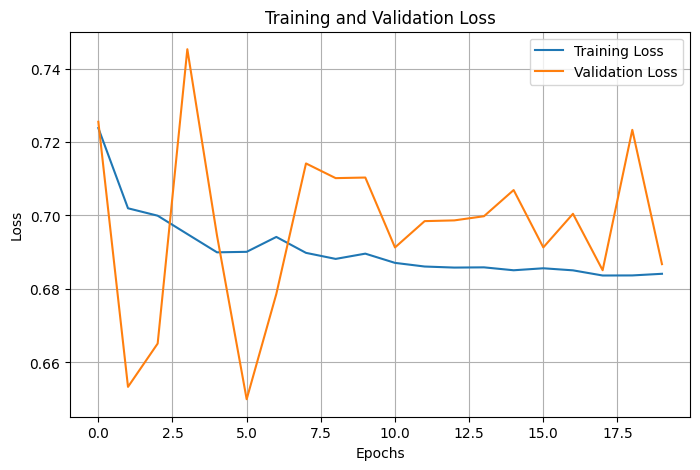

In [8]:
# Show training loss
training_results = os.path.join(c.TrainCTLearnModel.output_dir, "training_log.csv")
loss = pd.read_csv(training_results)


plt.figure(figsize=(8,5))
plt.plot(loss["epoch"], loss["loss"], label="Training Loss")
plt.plot(loss["epoch"], loss["val_loss"], label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Show model summary
model = tf.keras.models.load_model(os.path.join(c.TrainCTLearnModel.output_dir, "ctlearn_model.cpk"))
model.summary()

Model: "CTLearn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 2)]       0         
                                                                 
 SingleCNN_block (Functiona  (None, 128)               102208    
 l)                                                              
                                                                 
 fc_type_1 (Dense)           (None, 512)               66048     
                                                                 
 fc_type_2 (Dense)           (None, 256)               131328    
                                                                 
 type (Dense)                (None, 2)                 514       
                                                                 
 softmax (Softmax)           (None, 2)                 0         
                                                     

### Calculate Metrics

In [9]:
# Calculate flops and small metrics
from tensorflow.python.framework import convert_to_constants

num_params = model.count_params()
input_data = tf.random.normal([1, 96, 96, 2])
# Convert model to graph function
concrete_func = tf.function(model).get_concrete_function(input_data)

# Get graph definition
frozen_func = convert_to_constants.convert_variables_to_constants_v2(concrete_func)
graph_def = frozen_func.graph.as_graph_def()

# Use profiler to calculate FLOPs
run_meta = tf.compat.v1.RunMetadata()
builder = tf.compat.v1.profiler.ProfileOptionBuilder
opts = builder(builder.float_operation()).build()
opts['output'] = 'none'

flops = tf.compat.v1.profiler.profile(
    graph=frozen_func.graph,
    run_meta=run_meta,
    cmd='op',
    options=opts
)

if flops is not None:
    total_flops = flops.total_float_ops / 1e9
    print(total_flops)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
2025-11-24 09:09:56,811 | WARNING | From /home/hugo/miniforge3/envs/ctlearn/lib/python3.10/site-packages/tensorflow/python/ops/nn_ops.py:5253: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
0.096798978


2025-11-24 09:09:56.776110: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-11-24 09:09:56.776329: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


In [10]:
def get_atomic_layers(model):
    visited = set()
    layer_list = []

    def _collect(layer):
        if id(layer) in visited:
            return
        visited.add(id(layer))

        # Skip InputLayer
        if isinstance(layer, tf.keras.layers.InputLayer):
            return

        # Recursively explore submodels without counting the model itself
        if isinstance(layer, tf.keras.Model):
            for sublayer in layer.layers:
                _collect(sublayer)
            return

        # Explore attributes for inner layers (custom blocks)
        for attr_name in dir(layer):
            try:
                attr = getattr(layer, attr_name)
            except Exception:
                continue
            if isinstance(attr, tf.keras.layers.Layer):
                _collect(attr)
            elif isinstance(attr, (list, tuple)):
                for obj in attr:
                    if isinstance(obj, tf.keras.layers.Layer):
                        _collect(obj)

        # Count layer if it has no sublayers (atomic)
        if not hasattr(layer, "layers") or len(getattr(layer, "layers", [])) == 0:
            layer_list.append((layer.name, layer.__class__.__name__))

    # Start from top-level layers
    for l in model.layers:
        _collect(l)

    return layer_list
layers = get_atomic_layers(model)
nb_layers = len(layers)

/tmp/ipykernel_2007/2037407968.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  attr = getattr(layer, attr_name)


### Testing model

In [7]:
# Perform predictions

# Prepare Prediction model
model = os.path.join(c.TrainCTLearnModel.output_dir, "ctlearn_model.cpk")
 

# Predict on every test file
particles = ["gamma"]
testing_events = 0
inference_time_global = 0
# Create result folder (clean if already existing)
shutil.rmtree(os.path.join(c.TrainCTLearnModel.output_dir, "predict"), ignore_errors=True)
os.makedirs(os.path.join(c.TrainCTLearnModel.output_dir, "predict"), exist_ok=True)
for particle in particles: 
        directory = os.path.join(ctlearn_mgr_config.training_samples_path, particle, "testv2")
        for filename in os.listdir(directory):
            if filename.endswith(".h5"):
                # Prepare new filename as output
                predict_file = os.path.basename(filename).split(".", 1)[0]
                input_url = os.path.join(directory, filename)
                # Create results file
                output_url = os.path.join(c.TrainCTLearnModel.output_dir, "predict", f"{predict_file}.h5")
                # Set the part of the config for testing
                test_config = c.TestCTLearnModel
                # Launch the prediction
                match c.TrainCTLearnModel.reco_tasks:
                    case "type":
                        if test_config.PredictCTLearnModel.DLImageReader.mode == "stereo":
                            model_predict = StereoPredictCTLearnModel(input_url=input_url, load_type_model_from=model, output_path=output_url, config=test_config)   
                        else:
                            model_predict = MonoPredictCTLearnModel(input_url=input_url, load_type_model_from=model, output_path=output_url)
                    case "energy":
                        if test_config.PredictCTLearnModel.DLImageReader.mode == "stereo":
                            model_predict = StereoPredictCTLearnModel(input_url=input_url, load_energy_model_from=model, output_path=output_url, config=test_config)   
                        else:
                            model_predict = MonoPredictCTLearnModel(input_url=input_url, load_energy_model_from=model, output_path=output_url)
                    case "skydirection":
                        model_predict = StereoPredictCTLearnModel(input_url=input_url, load_skydirection_model_from=model, output_path=output_url, config=test_config)
                    case "cameradirection":
                        model_predict = MonoPredictCTLearnModel(input_url=input_url, load_cameradirection_model_from=model, output_path=output_url)
                    case _:
                        print("ERROR")
                start = time.time()
                try:
                    model_predict.run()
                except SystemExit as e:
                    print(f"Caught SystemExit ({e.code}, continuing...)")
                stop = time.time()
                testing_events += model_predict.dl1dh_reader._get_n_events()
                inference_time_global += (stop - start) * 1000 # ms

2026-01-05 14:20:32,803 WARNING [ctlearn.ctlearn-predict-stereo-model] (loader._handle_unrecognized_alias): Unrecognized alias: 'f', it will have no effect.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2026-01-05 14:20:33,058 | INFO | Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2026-01-05 14:20:33,397 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output


2026-01-05 14:20:33,417 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): mode: stereo
2026-01-05 14:20:33,418 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): stack: True
2026-01-05 14:20:33,419 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): config: {'data_path': '/home/hugo/TM/data/samples/', 'PredictCTLearnModel': {'stack_telescope_images': True, 'DLImageReader': {'mode': 'stereo'}}, 'f': DeferredConfigString('/home/hugo/.local/share/jupyter/runtime/kernel-43c46a10-537c-45db-b713-f76551275ccd.json')}


2026-01-05 14:20:33,486 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Simulation Run Identifier != Observation Block ID).  Using Observation Block ID for merged output


1/1 [==============================] - 0s 137ms/step
2026-01-05 14:20:34,686 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Simulation Run Identifier != Observation Block ID).  Using Observation Block ID for merged output


Caught SystemExit (0, continuing...)


2026-01-05 14:20:34,878 WARNING [ctlearn.ctlearn-predict-stereo-model] (loader._handle_unrecognized_alias): Unrecognized alias: 'f', it will have no effect.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2026-01-05 14:20:35,114 | INFO | Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2026-01-05 14:20:35,429 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output


2026-01-05 14:20:35,448 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): mode: stereo
2026-01-05 14:20:35,449 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): stack: True
2026-01-05 14:20:35,450 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): config: {'data_path': '/home/hugo/TM/data/samples/', 'PredictCTLearnModel': {'stack_telescope_images': True, 'DLImageReader': {'mode': 'stereo'}}, 'f': DeferredConfigString('/home/hugo/.local/share/jupyter/runtime/kernel-43c46a10-537c-45db-b713-f76551275ccd.json')}


2026-01-05 14:20:35,509 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Simulation Run Identifier != Observation Block ID).  Using Observation Block ID for merged output


1/1 [==============================] - 0s 53ms/step
2026-01-05 14:20:36,575 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Simulation Run Identifier != Observation Block ID).  Using Observation Block ID for merged output


Caught SystemExit (0, continuing...)


2026-01-05 14:20:36,727 WARNING [ctlearn.ctlearn-predict-stereo-model] (loader._handle_unrecognized_alias): Unrecognized alias: 'f', it will have no effect.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2026-01-05 14:20:36,956 | INFO | Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2026-01-05 14:20:37,246 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output


2026-01-05 14:20:37,265 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): mode: stereo
2026-01-05 14:20:37,265 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): stack: True
2026-01-05 14:20:37,266 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): config: {'data_path': '/home/hugo/TM/data/samples/', 'PredictCTLearnModel': {'stack_telescope_images': True, 'DLImageReader': {'mode': 'stereo'}}, 'f': DeferredConfigString('/home/hugo/.local/share/jupyter/runtime/kernel-43c46a10-537c-45db-b713-f76551275ccd.json')}


2026-01-05 14:20:37,325 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Simulation Run Identifier != Observation Block ID).  Using Observation Block ID for merged output


1/1 [==============================] - 0s 195ms/step
2026-01-05 14:20:38,901 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Simulation Run Identifier != Observation Block ID).  Using Observation Block ID for merged output


2026-01-05 14:20:39,068 WARNING [ctlearn.ctlearn-predict-stereo-model] (loader._handle_unrecognized_alias): Unrecognized alias: 'f', it will have no effect.


Caught SystemExit (0, continuing...)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2026-01-05 14:20:39,327 | INFO | Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2026-01-05 14:20:39,664 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Observation Block ID != Simulation Run Identifier).  Using Simulation Run Identifier for merged output


2026-01-05 14:20:39,685 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): mode: stereo
2026-01-05 14:20:39,685 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): stack: True
2026-01-05 14:20:39,686 WARNING [ctlearn.ctlearn-predict-stereo-model] (predict_model.setup): config: {'data_path': '/home/hugo/TM/data/samples/', 'PredictCTLearnModel': {'stack_telescope_images': True, 'DLImageReader': {'mode': 'stereo'}}, 'f': DeferredConfigString('/home/hugo/.local/share/jupyter/runtime/kernel-43c46a10-537c-45db-b713-f76551275ccd.json')}


2026-01-05 14:20:39,751 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Simulation Run Identifier != Observation Block ID).  Using Observation Block ID for merged output


1/1 [==============================] - 0s 84ms/step
2026-01-05 14:20:40,863 | WARNING | MergeConflictWarning: In merged column 'obs_id' the 'description' attribute does not match (Simulation Run Identifier != Observation Block ID).  Using Observation Block ID for merged output
Caught SystemExit (0, continuing...)


In [11]:
print(inference_time_global)
print(testing_events)

31927.582502365112
2791


### Build Complexity metrics file

In [12]:
metrics = {
    "num_params": num_params,
    "layers": nb_layers,
    "training_ms": training_time,
    "inference_ms": inference_time_global,
    "estimated_flops": total_flops,
    "training_events": training_events,
    "testing_events": testing_events
}
with open(os.path.join(c.TrainCTLearnModel.output_dir, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=4)

### Analyze results of prediction

In [7]:
# Evaluate results for particle type
if RECO == "type":
    # Predictions files
    prediction_directory = os.path.join(c.TrainCTLearnModel.output_dir, "predict")
    
    # Prepare DataFrame and mapping for classes
    global_predictions_df = pd.DataFrame()
    mapping = {0: 1, 101: 0}
    mapping_name = {0: "Gamma", 101: "Proton"}
    # Process prediction elements
    for file in os.listdir(prediction_directory):
            filename = os.path.join(prediction_directory, file)
            if filename.endswith(".h5"):
                with h5py.File(filename, 'r') as data:
                    # Get DL2 predictions
                    if 'dl2/event/subarray/classification/CTLearn' in data:
                        # Predictions
                        pred_ds = data['dl2/event/subarray/classification/CTLearn']['event_id', 'CTLearn_prediction', 'CTLearn_is_valid']
                        pred_ds = pd.DataFrame(pred_ds)
                        
                        # Take only valid events
                        pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                        
                        # Ground truth
                        ground_truth = data["simulation/event/subarray/shower"][:]
                        ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_shower_primary_id"])

                        # Combine ground truth with prediction
                        combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                        combined_df["particle_id"] = combined_df["true_shower_primary_id"].map(mapping)
                        combined_df["particle_name"] = combined_df["true_shower_primary_id"].map(mapping_name)

                        # Merge with others result files
                        global_predictions_df = pd.concat([global_predictions_df, combined_df], ignore_index=True)

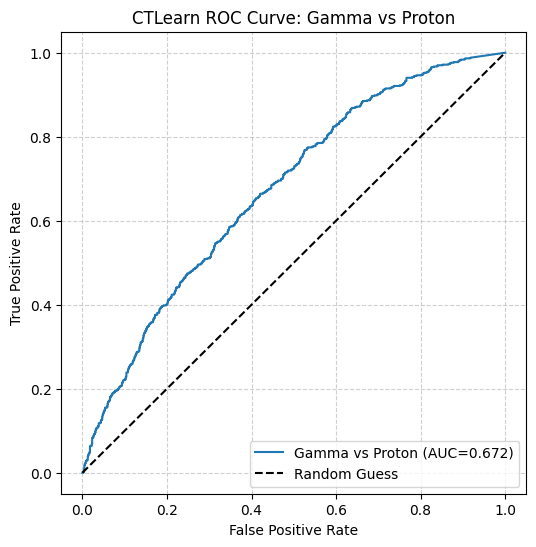

In [8]:
if RECO == "type":
    # Calculate ROC and AUC
    fpr_gamma, tpr_gamma, thresholds_gamma = metrics.roc_curve(global_predictions_df["particle_id"], global_predictions_df['CTLearn_prediction'], pos_label=1)
    auc_gamma = metrics.auc(fpr_gamma, tpr_gamma) 
    plt.figure(figsize=(6,6))
    # Calculate ROC
    plt.plot(fpr_gamma, tpr_gamma, label=f"Gamma vs Proton (AUC={auc_gamma:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("CTLearn ROC Curve: Gamma vs Proton")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

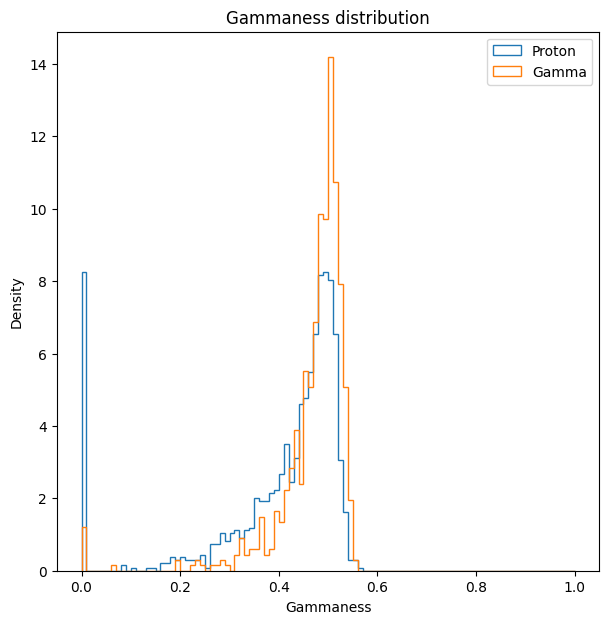

In [9]:
if RECO == "type":
    # Get uniques particles
    particles_type = global_predictions_df["particle_name"].unique()
    
    plt.figure(figsize=(7,7))
    
    # Display points for each particle type
    for particle in particles_type:
        particle_data = global_predictions_df[global_predictions_df["particle_name"] == particle]
        plt.hist(
            particle_data["CTLearn_prediction"],
            bins=100,
            range=(0, 1),
            histtype="step",
            density=True,
            label=particle,
        )
    plt.title("Gammaness distribution")
    plt.xlabel("Gammaness")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

[[1077  268]
 [ 401  269]]


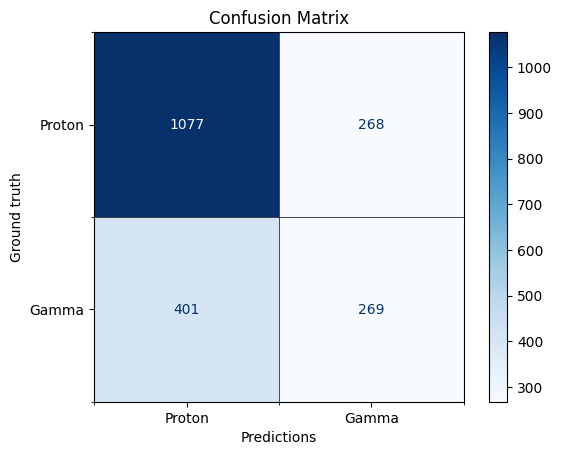

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

threshold = 0.5
def apply_corrected_predictions(row):
    if row["CTLearn_prediction"] >= threshold:
        return 1 # Gamma id
    else:
        return 0 # Proton (Hadron) id
# Extract necessary information to calculate metrics
predicted_values = global_predictions_df.apply(apply_corrected_predictions, axis=1)
ground_truth = global_predictions_df["particle_id"]
cm = confusion_matrix(ground_truth, predicted_values)
print(cm)

labels = global_predictions_df["particle_name"].unique()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel("Ground truth")
plt.xlabel("Predictions")
plt.xticks(np.arange(-0.5, cm.shape[1], 0.5), minor=True)
plt.yticks(np.arange(-0.5, cm.shape[0], 0.5), minor=True)
plt.grid(which="minor", color="black", linewidth=0.5)
plt.show()

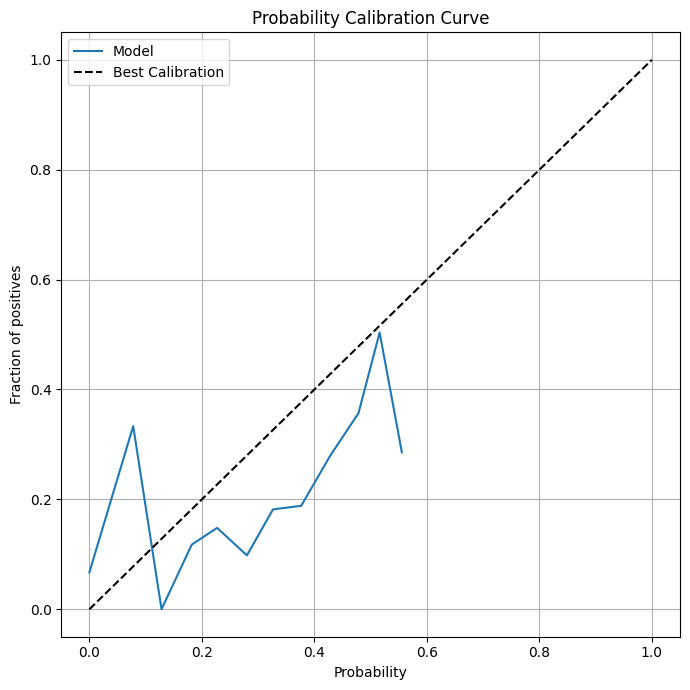

In [41]:
from sklearn.calibration import calibration_curve

predicted_values = global_predictions_df["CTLearn_prediction"]
ground_truth = global_predictions_df["particle_id"]
fraction_of_positives, mean_predicted_value = calibration_curve(
    ground_truth, predicted_values, n_bins=20, strategy="uniform"
)
plt.figure(figsize=(7, 7))
plt.plot(mean_predicted_value, fraction_of_positives, label=f"Model")
plt.plot([0, 1], [0, 1], "--", label="Best Calibration", color="black")

plt.title("Probability Calibration Curve")
plt.xlabel("Probability [%]")
plt.ylabel("Fraction of positives [%]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Find SkyDirection params
file = os.path.join("/home/hugo/TM/ml/models/cameradirection/test/predict/gamma_200_800E3GeV_20_20deg_ATM52_100575.h5")
with h5py.File(file, "r") as f:
    print("Keys in file:", list(f.keys()))
    structure = False
    if structure: 
        def print_structure(name, obj):
            print(name, "->", type(obj))
        f.visititems(print_structure)

    def search_h5_attributes(filename, substring):
        results = []
    
        def visit(name, obj):
            # Search in attribute names + attribute string values
            for attr_name, attr_value in obj.attrs.items():
    
                found = False
    
                # Check name
                if substring.lower() in attr_name.lower():
                    found = True
    
                # Check value if it is string-like
                if isinstance(attr_value, (str, bytes)):
                    if substring.lower() in str(attr_value).lower():
                        found = True
    
                if found:
                    results.append(
                        (name, attr_name, attr_value)
                    )
    
        with h5py.File(filename, "r") as f:
            f.visititems(visit)
    
        return results


    # Run search
    #matches = search_h5_attributes(file, "altitude")

    #print(f"\n=== Found {len(matches)} matching attributes ===")
    #for path, attr, value in matches:
    #    print(f"[{path}]  attribute '{attr}' = {value}")

    # For skydirection (in degrees)
    data = f['simulation/event/subarray/shower']
    # For camera (in radians)
    tel_001 = f["dl1/monitoring/telescope/pointing/tel_001"]["altitude", "azimuth"]
    tel_002 = f["dl1/monitoring/telescope/pointing/tel_002"]["altitude", "azimuth"]
    print(f"Tel 1 = Azimuth : {(np.unique(tel_001['azimuth']) /np.pi*180)}, Altitude : {(np.unique(tel_001['altitude']) /np.pi*180)}")
    print(f"Tel 2 = Azimuth : {(np.unique(tel_002['azimuth']) /np.pi*180)}, Altitude : {(np.unique(tel_002['altitude']) /np.pi*180)}")
    print(f"Truth = Azimuth : {np.mean(data['true_az'])}, Altitude : {np.mean(data['true_alt'])}")
    print(f["simulation/event/subarray/shower"].dtype)

Keys in file: ['configuration', 'dl1', 'dl2', 'r1', 'simulation']
Tel 1 = Azimuth : [175.1963], Altitude : [69.99999]
Tel 2 = Azimuth : [175.1963], Altitude : [69.99999]
Truth = Azimuth : 175.6877001634017, Altitude : 69.54612603510239
[('obs_id', '<i4'), ('event_id', '<i8'), ('true_energy', '<f8'), ('true_alt', '<f8'), ('true_az', '<f8'), ('true_core_x', '<f8'), ('true_core_y', '<f8'), ('true_h_first_int', '<f8'), ('true_x_max', '<f8'), ('true_starting_grammage', '<f8'), ('true_shower_primary_id', '<i8')]


In [10]:
# Wanted data for direction ["", "", "", "", ""]
if RECO == "direction":
    # Predictions files
    prediction_directory = os.path.join(c.TrainCTLearnModel.output_dir, "predict")
    mapping_name = {0: "Gamma", 101: "Proton"}
    global_predictions_df = pd.DataFrame()
    
    for file in os.listdir(prediction_directory):
            filename = os.path.join(prediction_directory, file)
            if filename.endswith(".h5"):
                with h5py.File(filename, 'r') as data:
                    # Get DL2 predictions
                    if 'dl2/event/subarray/geometry/CTLearn' in data:
                        # Predictions
                        pred_ds = data['dl2/event/subarray/geometry/CTLearn']['event_id', 'CTLearn_alt', 'CTLearn_az', 'CTLearn_is_valid']
                        pred_ds = pd.DataFrame(pred_ds)
                        pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                        
                        # Ground Truth
                        ground_truth = data["simulation/event/subarray/shower"][:]
                        ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_energy", "true_az", "true_alt", "true_shower_primary_id"])

                        # Get telescope (camera coordinates)
                        pointing_coordinates = data["dl1/monitoring/telescope/pointing/tel_001"]["altitude", "azimuth"]
                        
                        
                        # Combine ground truth with prediction
                        combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                        combined_df["particle_name"] = combined_df["true_shower_primary_id"].map(mapping_name)
                        combined_df["altitude"] = np.unique(pointing_coordinates["altitude"])[0]
                        combined_df["azimuth"] = np.unique(pointing_coordinates["azimuth"])[0]
                        
                        # Merge with others result files
                        global_predictions_df = pd.concat([global_predictions_df, combined_df], ignore_index=True)


/tmp/ipykernel_2363/481180708.py:16: UserWarning: You passed a edgecolor/edgecolors ('#cf004b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


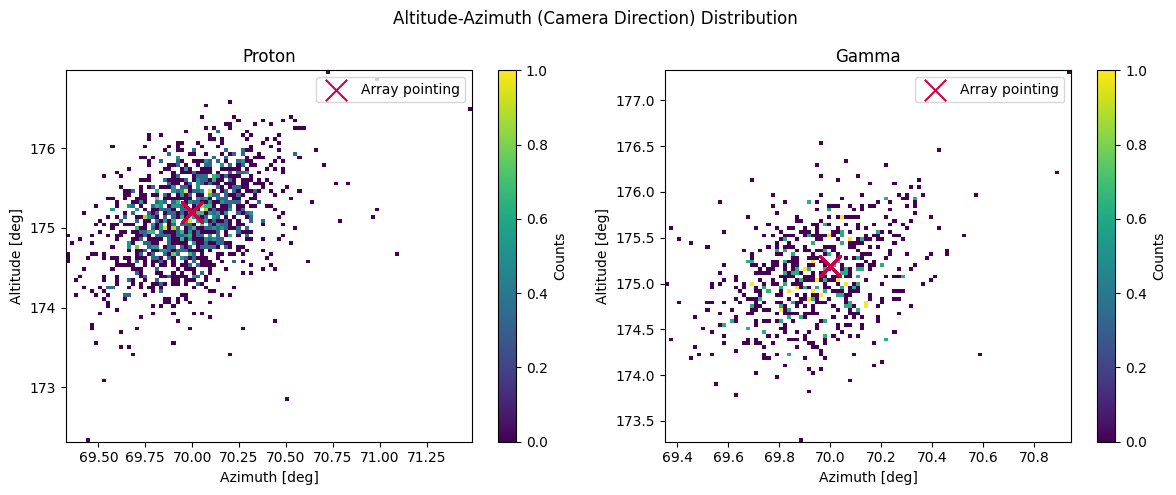

In [12]:
fig, axs = plt.subplots(1, len(global_predictions_df["particle_name"].unique()), figsize=(12, 5))
# Loop for each particles
for i, particle in enumerate(global_predictions_df["particle_name"].unique()):
    # flatten if only one particle type
    if len(global_predictions_df["particle_name"].unique()) > 1:
        ax = axs[i]
    else:
        ax = axs

    # get corresponding data    
    particle_df = global_predictions_df[global_predictions_df["particle_name"] == particle]

    
    
    # Provide a pointing area of the data individually
    ax.scatter(
        particle_df["altitude"] / np.pi * 180,
        particle_df["azimuth"] / np.pi * 180,
        color="#cf004b",
        label="Array pointing",
        marker="x",
        s=240,
        edgecolor="#cf004b"
    )
  
    # Provide histogram of camera direction using degrees
    ax.hist2d(
        particle_df["CTLearn_alt"],
        particle_df["CTLearn_az"],
        bins=100,
        zorder=0,
        cmap="viridis",
        norm=plt.cm.colors.LogNorm(),
    )      

    # Finish graph visualisation
    ax.set_ylabel("Altitude [deg]")
    ax.set_xlabel("Azimuth [deg]")
    ax.legend()
    ax.set_title(f"{particle}")
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label("Counts")
    
fig.suptitle("Altitude-Azimuth (Camera Direction) Distribution")
plt.tight_layout()
plt.show()

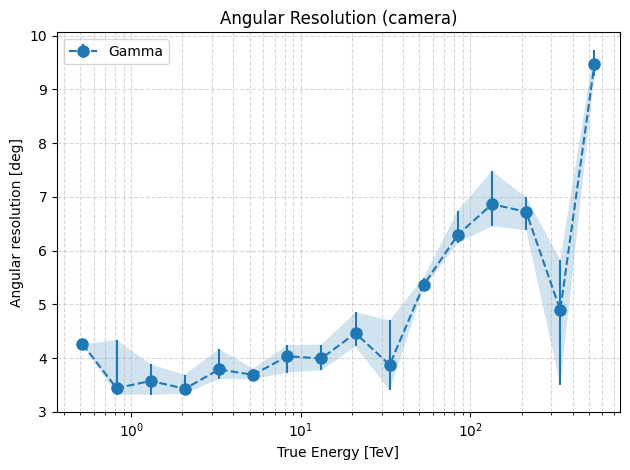

In [21]:
import ctaplot
import astropy.units as u

energy_true = global_predictions_df["true_energy"]
alt_true = global_predictions_df["true_alt"]
alt_pred = global_predictions_df["CTLearn_alt"]
az_true = global_predictions_df["true_az"]
az_pred = global_predictions_df["CTLearn_az"]


# Build bins (0.1–100 TeV)
log_bins = (
    np.logspace(
        np.log10(min(energy_true)),
        np.log10(max(energy_true)),
        num=int(
            np.log10(max(energy_true) / min(energy_true))
            * 5
        )
        + 1,
    )
    * u.TeV
)

e_bins, ang_res_err = ctaplot.angular_resolution_per_energy(
    (np.array(alt_true.values) * u.deg),
    (np.array(alt_pred.values) * u.deg),
    (np.array(az_true.values) * u.deg),
    (np.array(az_pred.values) * u.deg),
    (np.array(energy_true.values) * u.TeV),
    bins=log_bins
)

e = (e_bins[:-1].value + e_bins[1:].value) / 2
ang_res = [e_r[0].value for e_r in ang_res_err]
ang_res_minus = [e_r[0].value - e_r[1].value for e_r in ang_res_err]
ang_res_plus = [e_r[2].value - e_r[0].value for e_r in ang_res_err]
ang_res_min = [e_r[1].value for e_r in ang_res_err]
ang_res_max = [e_r[2].value for e_r in ang_res_err]
plt.errorbar(e,
            ang_res,
            yerr=[ang_res_minus, ang_res_plus],
            label="Gamma",
            markersize=8,
            marker="o",
            ls="--",
)
plt.fill_between(e, ang_res_min, ang_res_max, alpha=0.2)
plt.xscale("log")
plt.xlabel("True Energy [TeV]")
plt.ylabel("Angular resolution [deg]")
plt.title("Angular Resolution (camera)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()

In [14]:
alt_true = global_predictions_df["true_alt"]
alt_pred = global_predictions_df["CTLearn_alt"]
az_true = global_predictions_df["true_az"]
az_pred = global_predictions_df["CTLearn_az"]

diff = np.abs(az_true - az_pred)


def coords_to_3D(az_deg, alt_deg):
    az = np.radians(az_deg)
    alt = np.radians(alt_deg)
    x = np.cos(alt) * np.cos(az)
    y = np.cos(alt) * np.sin(az)
    z = np.sin(alt)
    return np.stack([x, y, z], axis=1)

def directional_error_deg(true_az, true_alt, pred_az, pred_alt):
    true_3d = coords_to_3D(true_az, true_alt)
    pred_3d = coords_to_3D(pred_az, pred_alt)
    dot = np.sum(true_3d * pred_3d, axis=1)
    dot = np.clip(dot, -1.0, 1.0)
    return np.degrees(np.arccos(dot))

directional_errors = directional_error_deg(az_true, alt_true,
                                               az_pred, alt_pred)

mdae = np.mean(directional_errors)
rmsde = np.sqrt(np.mean(directional_errors**2))

maae_circular = np.mean(np.minimum(diff, 360-diff))
maae_linear = np.mean(np.abs(alt_true - alt_pred))
print(f"MDAE : {mdae}")
print(f"MAAE Circular : {maae_circular}")
print(f"RMSDE : {rmsde}")
print(f"MAAE Linear : {maae_linear}")

MDAE : 3.6642816276005292
MAAE Circular : 6.957008394175305
RMSDE : 4.136960162102691
MAAE Linear : 2.2774124337274992


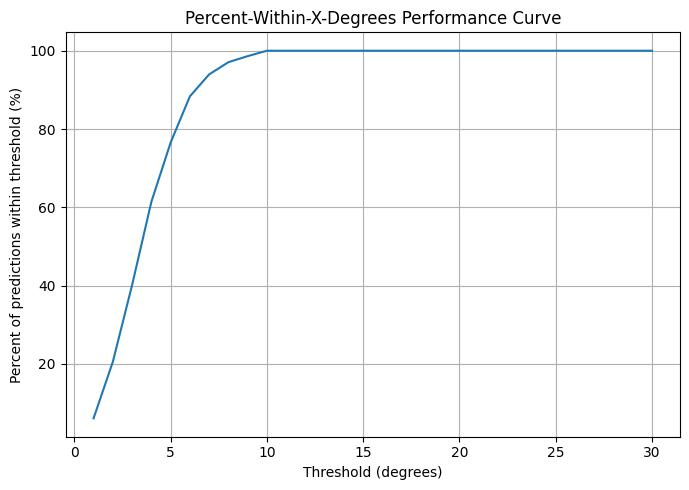

In [15]:
directional_errors = directional_error_deg(az_true, alt_true,
                                               az_pred, alt_pred)


thresholds = np.arange(1, 31)

percentages = []
total = len(directional_errors)
for t in thresholds:
    p = np.sum(directional_errors <= t) / total * 100
    percentages.append(p)
percentages = np.array(percentages)

plt.figure(figsize=(7,5))
plt.plot(thresholds, percentages)
plt.xlabel("Threshold (degrees)")
plt.ylabel("Percent of predictions within threshold (%)")
plt.title("Percent-Within-X-Degrees Performance Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

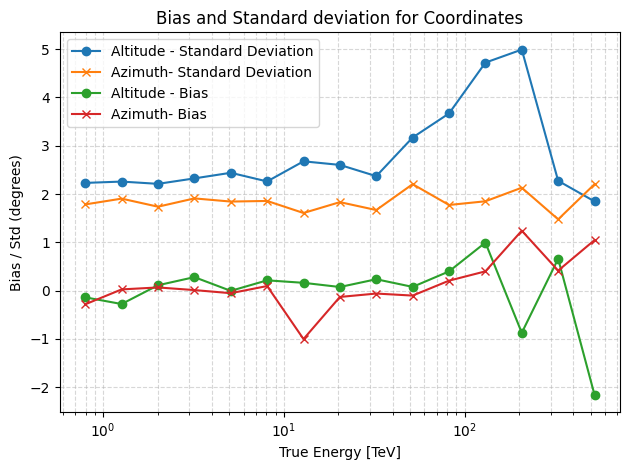

In [19]:
from scipy.stats import norm
energy_true = global_predictions_df["true_energy"]
            
# Build bins
bins = (
    np.logspace(
        np.log10(min(energy_true)),
        np.log10(max(energy_true)),
        num=int(
            np.log10(max(energy_true) / min(energy_true))
            * 5
        )
        + 1,
    )
)

alt_err = alt_pred - alt_true
az_err = np.arctan2(np.sin(az_pred - az_true), np.cos(az_pred - az_true))


# Assign events to bins
indices = np.digitize(energy_true, bins)
results_alt = []
results_az = []

# For each bin
for i in range(1, len(bins)):
    # Check if enough data in a bin
    mask = indices == i
    if np.sum(mask) < 20:
        continue

    alt_bin = alt_err[mask]
    mu_alt, sigma_alt = norm.fit(alt_bin)

    az_bin = az_err[mask]
    mu_az, sigma_az = norm.fit(az_bin)


    represent_energy = np.sqrt(bins[i-1] * bins[i])
    
    results_alt.append({
        "represent_energy": represent_energy,
        "mean_bias": mu_alt,
        "sigma": sigma_alt
    })

    results_az.append({
        "represent_energy": represent_energy,
        "mean_bias": mu_az,
        "sigma": sigma_az
    })  

alt_line = pd.DataFrame(results_alt)
az_line  = pd.DataFrame(results_az)

# Add standard deviation to graph
plt.plot(alt_line["represent_energy"], alt_line["sigma"], "o-", label="Altitude - Standard Deviation")
plt.plot(az_line["represent_energy"], az_line["sigma"], "x-", label="Azimuth- Standard Deviation")

# Add bias to graph
plt.plot(alt_line["represent_energy"], alt_line["mean_bias"], "o-", label="Altitude - Bias")
plt.plot(az_line["represent_energy"], az_line["mean_bias"], "x-", label="Azimuth- Bias")

# Compute graphic
plt.xscale("log")
plt.xlabel("True Energy [TeV]")
plt.ylabel("Bias / Std (degrees)")
plt.title("Bias and Standard deviation for Direction")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Evaluate results for particle type
if RECO == "energy":
    # Predictions files
    prediction_directory = os.path.join(c.TrainCTLearnModel.output_dir, "predict")
    mapping_name = {0: "Gamma", 101: "Proton"}
    global_predictions_df = pd.DataFrame()
    
    for file in os.listdir(prediction_directory):
            filename = os.path.join(prediction_directory, file)
            if filename.endswith(".h5"):
                with h5py.File(filename, 'r') as data:
                    # Get DL2 predictions
                    if 'dl2/event/subarray/energy/CTLearn' in data:
                        # Predictions
                        pred_ds = data['dl2/event/subarray/energy/CTLearn']['event_id', 'CTLearn_energy', 'CTLearn_is_valid', 'CTLearn_energy_uncert']
                        pred_ds = pd.DataFrame(pred_ds)
                        pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                        
                        # Ground Truth
                        ground_truth = data["simulation/event/subarray/shower"][:]
                        ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_energy", "true_shower_primary_id"])
                        
                        # Combine ground truth with prediction
                        combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                        combined_df["particle_name"] = combined_df["true_shower_primary_id"].map(mapping_name)
                        
                        # Merge with others result files
                        global_predictions_df = pd.concat([global_predictions_df, combined_df], ignore_index=True)


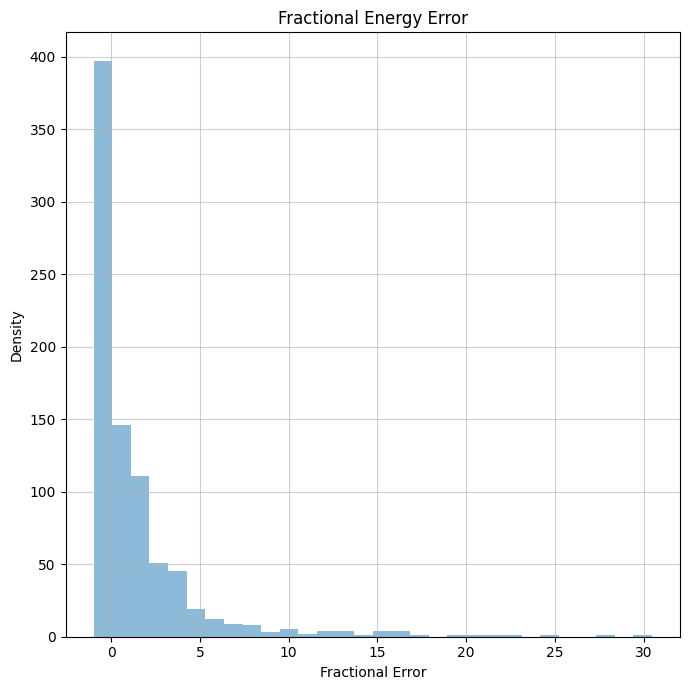

In [9]:
if RECO == "energy":
    # Get uniques particles
    true = global_predictions_df["true_energy"]
    pred = global_predictions_df["CTLearn_energy"]

    fractional_error = (pred - true) / true
    
    
    plt.figure(figsize=(7,7))
    
    # Display points for each particle type
    plt.hist(fractional_error, bins=30, alpha=0.5, density=False)
    plt.xlabel("Fractional Error")
    plt.ylabel("Density")
    plt.title("Fractional Energy Error")
    plt.grid(True, alpha=0.6)
    plt.tight_layout()
    plt.show()

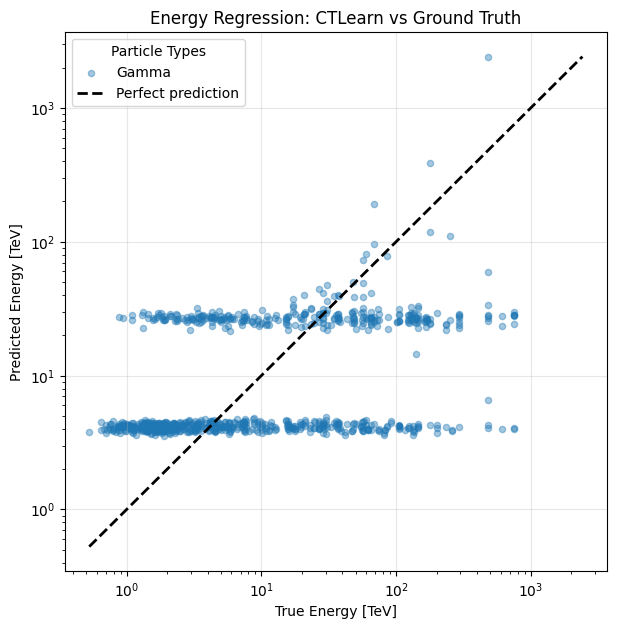

In [10]:
if RECO == "energy":
    # Get uniques particles
    particles_type = global_predictions_df["particle_name"].unique()
    
    plt.figure(figsize=(7,7))
    
    # Display points for each particle type
    for particle in particles_type:
        particle_data = global_predictions_df[global_predictions_df["particle_name"] == particle]
        plt.scatter(particle_data["true_energy"], particle_data["CTLearn_energy"], 
                    alpha=0.4, label=particle, s=20)
    
    lims = [min(global_predictions_df["true_energy"].min(), global_predictions_df["CTLearn_energy"].min()), 
            max(global_predictions_df["true_energy"].max(), global_predictions_df["CTLearn_energy"].max())]
    plt.plot(lims, lims, 'k--', lw=2, label="Perfect prediction")
    plt.xlabel("True Energy [TeV]")
    plt.ylabel("Predicted Energy [TeV]")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(title="Particle Types")
    plt.title("Energy Regression: CTLearn vs Ground Truth")
    plt.grid(alpha=0.3)
    plt.show()

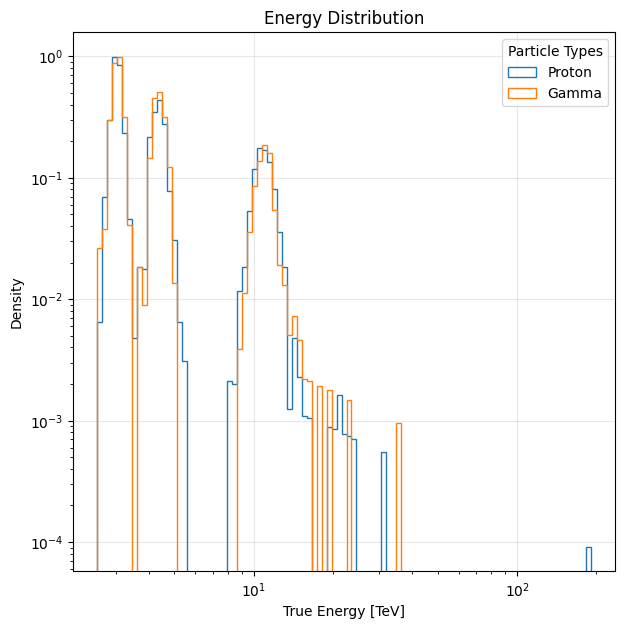

In [13]:
if RECO == "energy":
    # Get uniques particles
    particles_type = global_predictions_df["particle_name"].unique()
    
    plt.figure(figsize=(7,7))

    # Prepare bins for graph
    log_bins = np.logspace(
        np.log10(global_predictions_df["CTLearn_energy"].min()),
        np.log10(global_predictions_df["CTLearn_energy"].max()),
        100,
    )
    
    # Display points for each particle type
    for particle in particles_type:
        particle_data = global_predictions_df[global_predictions_df["particle_name"] == particle]

        # Build histogram
        plt.hist(
            particle_data["CTLearn_energy"],
            bins=log_bins,
            range=(0, 1),
            histtype="step",
            density=True,
            label=particle,
        )
    # Show graphic
    plt.xlabel("True Energy [TeV]")
    plt.ylabel("Density")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(title="Particle Types")
    plt.title("Energy Distribution")
    plt.grid(alpha=0.3)
    plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Example: true directions
alt_true = global_predictions_df["true_alt"]
alt_pred = global_predictions_df["CTLearn_alt"]
az_true = global_predictions_df["true_az"]
az_pred = global_predictions_df["CTLearn_az"]

x_true = np.cos(np.radians(alt_true)) * np.cos(np.radians(az_true))
y_true = np.cos(np.radians(alt_true)) * np.sin(np.radians(az_true))

x_pred = np.cos(np.radians(alt_pred)) * np.cos(np.radians(az_pred))
y_pred = np.cos(np.radians(alt_pred)) * np.sin(np.radians(az_pred))

# Compute error vectors
U = x_pred - x_true
V = y_pred - y_true

plt.figure(figsize=(10,6))
plt.quiver(az_true, alt_true, U, V, angles='xy', scale_units='xy', scale=0.1)
plt.xlabel("Azimuth (°)")
plt.ylabel("Altitude (°)")
plt.title("Quiver Plot of Direction Prediction Errors")
plt.grid(True)
plt.show()

KeyError: 'true_alt'

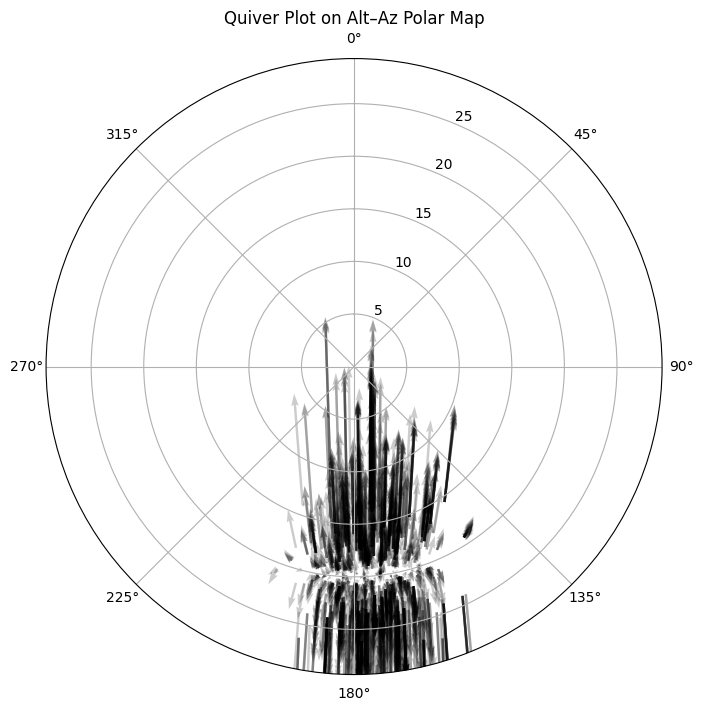

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Example altitude (converted to polar radius = 90 - altitude)
r = 90 - alt_true
theta = np.radians(az_true)

dr = - (alt_pred - alt_true)  # radial difference
dtheta = np.radians(az_pred - az_true)  # angular difference

plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
ax.quiver(theta, r, dtheta, dr, scale=30, width=0.004, alpha=0.2)

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.set_title("Quiver Plot on Alt–Az Polar Map")
plt.show()